In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
import np_utils
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


2023-12-23 19:18:04.141454: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 19:18:04.141481: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 19:18:04.141507: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 19:18:04.148102: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Preparation

### Ravdess Dataframe

Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


In [2]:
RavdessSpeech = "Dataset/Audio_Speech_Actors_01-24/"

ravdess_speech_directory_list = os.listdir(RavdessSpeech)

file_emotion = []
file_path = []
file_name = []
for dir in ravdess_speech_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(RavdessSpeech + dir)
    for file in actor:
        # take the name file before the '.wav'
        part = file.split('.')[0]
        file_name.append(part)
        # take the various number a part from each other to classify the dataset according to these informations
        part = part.split('-')
        # third number in each name file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(RavdessSpeech + dir + '/' + file)
        
# dataframe for emotion of files
emotion_speech_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_speech_df = pd.DataFrame(file_path, columns=['Path'])

# dataframe for name of files.
name_speech_df = pd.DataFrame(file_name, columns=['Name'])

Ravdess_speech_df = pd.concat([emotion_speech_df, path_speech_df, name_speech_df], axis=1)

# changing integers to actual emotions.
Ravdess_speech_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_speech_df.head()

,Emotions,Path,Name
0,disgust,Dataset/Audio_Speech_Actors_01-24/Actor_01/03-...,03-01-07-01-01-02-01
1,disgust,Dataset/Audio_Speech_Actors_01-24/Actor_01/03-...,03-01-07-01-02-01-01
2,disgust,Dataset/Audio_Speech_Actors_01-24/Actor_01/03-...,03-01-07-01-02-02-01
3,disgust,Dataset/Audio_Speech_Actors_01-24/Actor_01/03-...,03-01-07-02-01-01-01
4,disgust,Dataset/Audio_Speech_Actors_01-24/Actor_01/03-...,03-01-07-02-01-02-01


In [3]:
RavdessSong = "Dataset/Audio_Song_Actors_01-24/"

ravdess_song_directory_list = os.listdir(RavdessSong)

file_emotion = []
file_path = []
file_name = []
for dir in ravdess_song_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(RavdessSong + dir)
    for file in actor:
        # take the name file before the '.wav'
        part = file.split('.')[0]
        file_name.append(part)
        # take the various number a part from each other to classify the dataset according to these informations
        part = part.split('-')
        # third number in each name file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(RavdessSong + dir + '/' + file)
        
# dataframe for emotion of files
emotion_song_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_song_df = pd.DataFrame(file_path, columns=['Path'])

# dataframe for name of files.
name_song_df = pd.DataFrame(file_name, columns=['Name'])

Ravdess_song_df = pd.concat([emotion_song_df, path_song_df, name_song_df], axis=1)

# changing integers to actual emotions.
Ravdess_song_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_song_df.head()

,Emotions,Path,Name
0,happy,Dataset/Audio_Song_Actors_01-24/Actor_01/03-02...,03-02-03-01-02-01-01
1,happy,Dataset/Audio_Song_Actors_01-24/Actor_01/03-02...,03-02-03-01-02-02-01
2,happy,Dataset/Audio_Song_Actors_01-24/Actor_01/03-02...,03-02-03-02-01-01-01
3,happy,Dataset/Audio_Song_Actors_01-24/Actor_01/03-02...,03-02-03-02-01-02-01
4,happy,Dataset/Audio_Song_Actors_01-24/Actor_01/03-02...,03-02-03-02-02-01-01


### make a concatenation of both Dataframe.

In [4]:
data_path = pd.concat([Ravdess_speech_df, Ravdess_song_df], axis = 0)
#save the new data set in csv
data_path.to_csv("data_path.csv",index=False)
data_path

,Emotions,Path,Name
0,disgust,Dataset/Audio_Speech_Actors_01-24/Actor_01/03-...,03-01-07-01-01-02-01
1,disgust,Dataset/Audio_Speech_Actors_01-24/Actor_01/03-...,03-01-07-01-02-01-01
2,disgust,Dataset/Audio_Speech_Actors_01-24/Actor_01/03-...,03-01-07-01-02-02-01
3,disgust,Dataset/Audio_Speech_Actors_01-24/Actor_01/03-...,03-01-07-02-01-01-01
4,disgust,Dataset/Audio_Speech_Actors_01-24/Actor_01/03-...,03-01-07-02-01-02-01
...,...,...,...
1007,calm,Dataset/Audio_Song_Actors_01-24/Actor_24/03-02...,03-02-02-02-01-02-24
1008,calm,Dataset/Audio_Song_Actors_01-24/Actor_24/03-02...,03-02-02-02-02-01-24
1009,calm,Dataset/Audio_Song_Actors_01-24/Actor_24/03-02...,03-02-02-02-02-02-24
1010,happy,Dataset/Audio_Song_Actors_01-24/Actor_24/03-02...,03-02-03-01-01-01-24


# Data visualisation

/home/circe/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/circe/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/circe/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


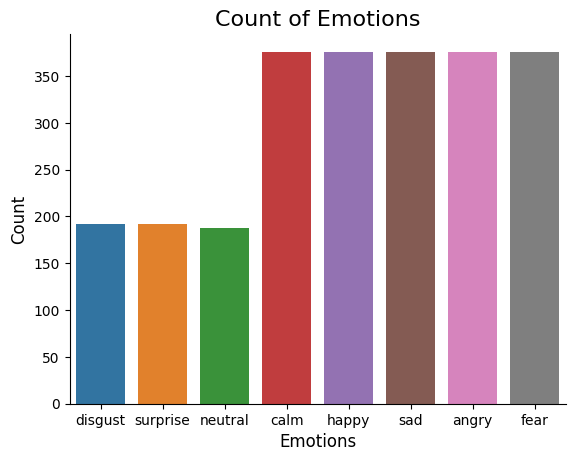

In [5]:
plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=data_path)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


<b><u> The difference of number of audio is explainable by the fact the the 'song' audio does not own the disgust and surprise emotions, then there is only the one from the 'speech' dataset. Also the 'neutral' emotion does not have differente intensity it implicate that there is half of the number of other emotions audio.</u></b>



We can also plot waveplots and spectograms for audio signals
* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.



In [6]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr, color="blue")
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [7]:

# select the audio
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[333]
#listen it
Audio(path)

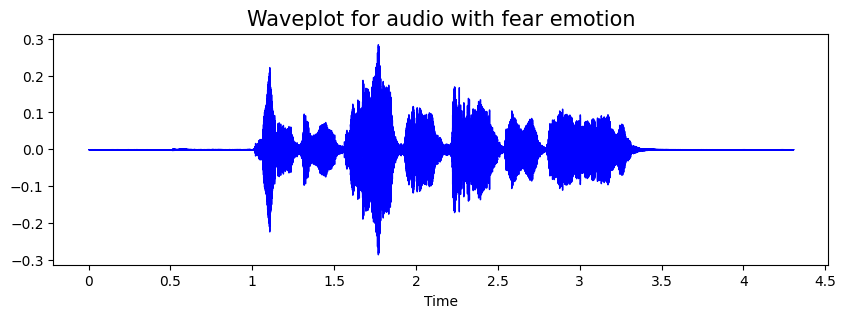

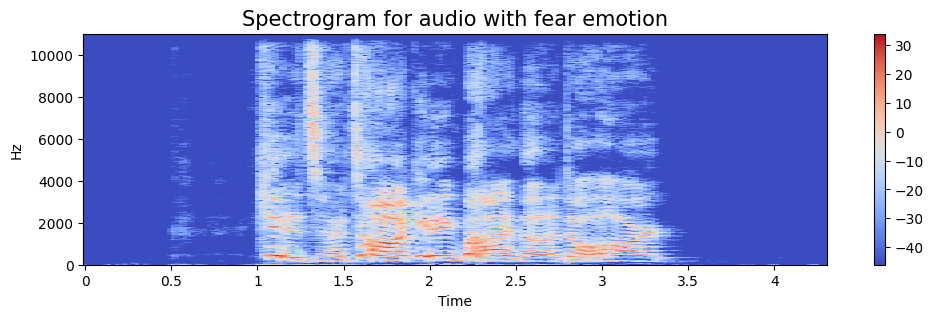

In [8]:
#transform the audio into data
data, sampling_rate = librosa.load(path)
#visualize a waveplot of the audio
create_waveplot(data, sampling_rate, emotion)
#vsualize a spectrogram of the audio
create_spectrogram(data, sampling_rate, emotion)

# Data augmentation

To improve the performance of a deep learning model, one of the best technique is to add data to the training set.

In the context of audio, we create new synthetic data samples by adding small perturbations on our initial training set. The perturbation that can be applied are noise injection, shifting time, changing pitch and speed. This will help the model to generalize it's comprehension of the data and makes it insensitive to small change in an audio.

This approach helps increase our dataset, minimize overfitting and so increase the performance of the model.

In our case, we are gonna use noising, streching and pitching because pitching does not really affect the audio files of our dataset. 

In [9]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [10]:
# Function to create and save transformed audio files
def create_transformed_audio(original_path, name_suffix):
    # Load the original audio file
    data, sampling_rate = librosa.load(original_path)
    
    # Apply transformations
    # Apply noise
    noisy_data = noise(data)
    # Apply stretch & pitch
    stretched_pitch_data = stretch(data)
    stretched_pitch_data = pitch(stretched_pitch_data, sampling_rate)

    name_stretchNpitch = name_suffix+'_stretchNpitch'
    name_noise = name_suffix+'_noise'

    # Save transformed audio files
    transformed_path_noise = f'Dataset/transformed/{name_noise}.wav'
    transformed_path_stretch_pitch = f'Dataset/transformed/{name_stretchNpitch}.wav'
    

    import soundfile as sf
    sf.write(transformed_path_noise, noisy_data, sampling_rate, subtype='PCM_24')
    sf.write(transformed_path_stretch_pitch, stretched_pitch_data, sampling_rate, subtype='PCM_24')
    
    return transformed_path_noise, name_noise, transformed_path_stretch_pitch, name_stretchNpitch


In [11]:
# Create 'transformed' directory if not exists
transformed_dir = 'Dataset/transformed'
if not os.path.exists(transformed_dir):
    os.makedirs(transformed_dir)

/home/circe/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/circe/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/circe/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


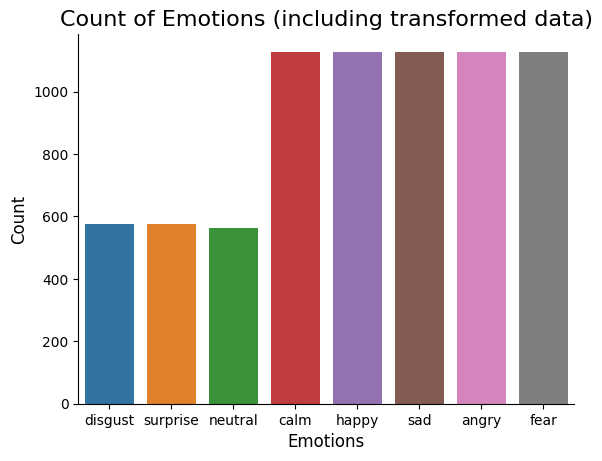

In [14]:
new_data_path = []
# Iterate through the original audio files in data_path
for index, row in data_path.iterrows():
    original_path = row['Path']
    emotion = row['Emotions']
    name = row['Name']

    path_noise, name_noise, path_strechNpitch, name_stretchNpich = create_transformed_audio(original_path, name)

    # Update path dataframe
    new_path_noise = pd.DataFrame({'Emotions': [emotion], 'Path': [path_noise], 'Name' : [name_noise]})
    new_path_stretchNpich = pd.DataFrame({'Emotions': [emotion], 'Path': [path_strechNpitch], 'Name' : [name_stretchNpich]})

    new_data_path.append(new_path_noise)
    new_data_path.append(new_path_stretchNpich)

# Concatenate the list of DataFrames
new_data_path_concatenated = pd.concat(new_data_path, ignore_index=True)

# Concatenate the original data_path DataFrame with the new_data_path_concatenated DataFrame
data_path = pd.concat([data_path, new_data_path_concatenated], ignore_index=True)


# Save updated data_path dataframe to CSV
data_path.to_csv("data_path_transformed.csv", index=False)

# Visualize the updated count of emotions
plt.title('Count of Emotions (including transformed data)', size=16)
sns.countplot(x='Emotions', data=data_path)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


# Extraction features


In [17]:
extracted_data = []
# Iterate through the original audio files in data_path
for index, row in data_path.iterrows():
    path = row['Path']
    emotion = row['Emotions']

    audio, sampling_rate = librosa.load(path)

    #Get Mel spectogram of audio
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sampling_rate)

    #Convert to log scale (DB)
    spectrogram = librosa.power_to_db(spectrogram)

    #Get MFCC and second derivatives
    # mfcc = librosa.feature.mfcc(S=spectrogram)

    #Append MFCC to spectrogram and flatten
    # features = np.concatenate((spectrogram,mfcc),axis=0)
    X = spectrogram.ravel()
    X_df = pd.DataFrame({'y' : [emotion], 'X' : [X]})

    extracted_data.append(X_df)

print(extracted_data)

[         y                                                  X
0  disgust  [-73.13351, -73.13351, -73.13351, -73.13351, -...,          y                                                  X
0  disgust  [-79.24819, -76.792404, -78.217384, -70.94328,...,          y                                                  X
0  disgust  [-75.957245, -75.957245, -75.957245, -75.95724...,          y                                                  X
0  disgust  [-59.912735, -59.912735, -59.912735, -59.91273...,          y                                                  X
0  disgust  [-56.270527, -59.48608, -59.48608, -59.48608, ...,          y                                                  X
0  disgust  [-63.603394, -63.603394, -63.603394, -63.60339...,          y                                                  X
0  disgust  [-58.715435, -58.715435, -58.715435, -58.71543...,           y                                                  X
0  surprise  [-72.16557, -72.16557, -72.16557, -72.16557, -..

In [23]:
display(extracted_data[0]["X"].to_string())

'0    [-73.13351, -73.13351, -73.13351, -73.13351, -...'

In [24]:
# extract the mean bands to its own feature columns
data = pd.DataFrame(extracted_data)
data.head()

ValueError: Must pass 2-d input. shape=(7356, 1, 2)

# Modeling
To create our model, we followed the architecture of the 2nd model proposed in this paper : https://abhayk1201.github.io/files/paper2.pdf

In [ ]:
# replace NA with 0
data = data.fillna(0)
print(data.shape)

#split the data
y = data["y"]
X = data.drop(columns=["y"])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [ ]:
#data normalization
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)

X_train = (x_train - mean)/std
X_test = (x_test - mean)/std


In [ ]:
#change the format for the model understanding
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [ ]:
# model design
model = Sequential()
model.add(Conv1D(filters=32,kernel_size=(3,3),activation="relu",
                padding="valid",
                kernel_regularizer=regularizers.l2(0.00001),
                input_shape=(100, 100, 3)))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1,activation="linear")) 

# Compiler le modèle en utilisant la fonction de perte 'mse', un 
# optimiseur 'adam' et la métrique ['mean_absolute_error']
model.compile(optimizer="adam",loss="mse",metrics=['mean_absolute_error'])

# Entraîner le modèle en utilisant la méthode fit_generator(). 
# On utilisera les paramètres suivants :
#   Les données utilisées sont le jeu de données d'entraînement augmenté train_dataset
#   Le jeu de données de test, validation_data est test_dataset
#   epochs = 20
#   steps_per_epochs = X_train.shape[0] // batch_size
#   Une liste comprenant les callbacks instanciés et le timer dans le paramètre callbacks
#   verbose = True
batch_size = 128
epochs = 20 
model_history = model.fit_generator(
            train_dataset, # use augmented images for train 
            steps_per_epoch=X_train.shape[0] // batch_size,
            validation_data = test_dataset, # use augmented images for test
            epochs = epochs,
            callbacks = [
                         reduce_learning_rate,
                         early_stopping,
                         time_callback
                        ],
            verbose=True)

# Stocker l'historique d'évolution de la fonction de perte à chaque
# epoch.
train_loss = model_history.history["loss"]
val_loss = model_history.history["val_loss"]
train_acc = model_history.history["mean_absolute_error"]
val_acc = model_history.history["val_mean_absolute_error"]

# Afficher l'évolution de la fonction de coût et de la précision en 
# fonction de l'epoch.
plt.figure(figsize = (20, 8))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss per epoch (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy per epoch (MAE)')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.show()